# Week 5-1: Breaking down Machine Bias

This notebook explores the classic ProPublica story [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). It uses the original data that the reporters collected for the story, through FOIA requests to Broward County, Florida.

The COMPAS score uses answers to [137 questions](https://www.documentcloud.org/documents/2702103-Sample-Risk-Assessment-COMPAS-CORE.html) to assign a risk score to defendents -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label

This analysis is based on ProPublica's [original notebook](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

There has been a lot of discussion about this story and its particular definition of fairness. The best overall reference is the [Fairness in Machine Learning
NIPS 2017 Tutorial](http://fairml.how) by Solon Barocas and Moritz Hardt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn import metrics
%matplotlib inline

This notebook is designed to let you select between data on arrests for non-violent or violent crimes. This allows quick comparisons of the difference between these two data sets.


There is some reason to suspect that arrest data for violent crime is both more accurate and less biased than non-violent crime data. See e.g. [Skeem and Lowenkamp](https://www.law.berkeley.edu/wp-content/uploads/2015/04/SSRN-id2687339.pdf). Also, we do get more accurate predictors wih the violent data (including COMPAS).


In [2]:
violent = False

if violent:
    fname ='compas-scores-two-years-violent.csv'
    decile_col = 'v_decile_score'
    score_col = 'v_score_text'
else:
    fname ='compas-scores-two-years.csv'
    decile_col = 'decile_score'
    score_col = 'score_text'


In [3]:
cv = pd.read_csv(fname)
cv.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
cv.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

Following ProPublica, we filter out certain rows which are missing data. As they put it:

- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [5]:
cv = cv[
    (cv.days_b_screening_arrest <= 30) &  
    (cv.days_b_screening_arrest >= -30) &  
    (cv.is_recid != -1) &
    (cv.c_charge_degree != 'O') &
    (cv[score_col] != 'N/A')
]

cv.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
cv.shape

(6172, 53)

## 1. A first look at the data 

Let's do some basic analysis on the demographics

In [6]:
# age value coutns
cv.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [7]:
# race value counts
cv.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

The COMPAS model predictions are in `v_decile_score` from 1 to 10, and low/med/high in `v_score_text`

In [8]:
# COMPAS decile score value counts
cv[decile_col].value_counts()

1     1286
2      822
4      666
3      647
5      582
6      529
7      496
9      420
8      420
10     304
Name: decile_score, dtype: int64

In [9]:
# COMPAS text score value counts
cv[score_col].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

We can look at the decile scores white and black to get our first look at how the COMPAS algorithm handles different races.

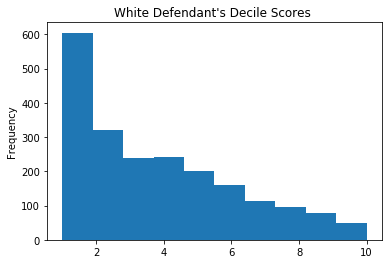

In [10]:
# Histogram of decile scores for White
cv[cv.race == 'Caucasian'][decile_col].plot(kind='hist', title='White Defendant\'s Decile Scores ')

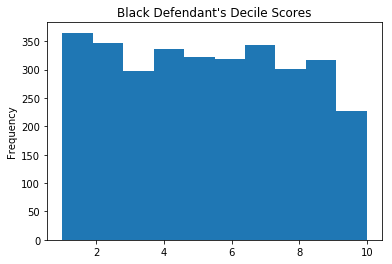

In [11]:
# Histogram of decile scores for Black
cv[cv.race == 'African-American'][decile_col].plot(kind='hist', title='Black Defendant\'s Decile Scores')

Meanwhile the `two_year_recid` field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.

In [12]:
# recidivism value counts
cv.two_year_recid.value_counts()

0    3363
1    2809
Name: two_year_recid, dtype: int64

Now we can start looking at the relationships between these variables. First, recidivism by race.


In [13]:
# recidivism rates by race
recid_race = pd.crosstab(cv.race, cv.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


Similarly for sex:

In [14]:
# recidivism rates by sex
recid_sex = pd.crosstab(cv.sex, cv.two_year_recid)
recid_sex['rate'] = recid_sex[1] / recid_sex.sum(axis=1)
recid_sex

two_year_recid,0,1,rate
sex,,,
Female,762,413,0.351489
Male,2601,2396,0.479488


There are significant differences in recidivisim in this population by race and gender. These are the "base rates" we will talk about more. However, there may also be significant differences in the composition of these populations -- they may have different age, criminal histories, etc.

Let's see how the COMPAS risk scores break down by race and gender.

In [15]:
# high risk rates by race
score_race = pd.crosstab(cv.race, cv[score_col])
score_race['High risk rate'] = score_race['High'] / score_race.sum(axis=1)
score_race

score_text,High,Low,Medium,High risk rate
race,,,,
African-American,845,1346,984,0.266142
Asian,3,24,4,0.096774
Caucasian,223,1407,473,0.106039
Hispanic,47,368,94,0.092338
Native American,4,3,4,0.363636
Other,22,273,48,0.064140


In [16]:
# high risk rates by sex
score_sex = pd.crosstab(cv.sex, cv[score_col])
score_sex['High risk rate'] = score_sex['High'] / score_sex.sum(axis=1)
score_sex

score_text,High,Low,Medium,High risk rate
sex,,,,
Female,151,699,325,0.128511
Male,993,2722,1282,0.198719


Generally, the fraction of people assigned a `high` risk is greater where the recidivism rates are also higher. 



## 2. Predictive calibration and accuracy
Being "accurate" in a predictive sense is only one type of "fairness," as we shall see, but it's still a desirable characteristic.

Let's start by looking at the proportion of people who are re-arrested in each decile score.

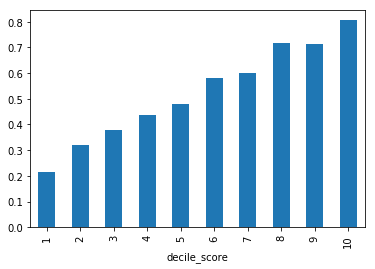

In [17]:
# probability of recidivism by decile
cv.groupby(decile_col).mean()['two_year_recid'].plot(kind='bar')

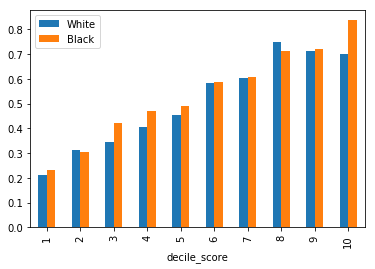

In [18]:
# probability of recidivism by decile and race
b = cv[cv.race=='African-American'].groupby([decile_col]).mean()['two_year_recid']
w = cv[cv.race=='Caucasian'].groupby([decile_col]).mean()['two_year_recid']

a = pd.concat([w,b], axis=1)
a.columns = ['White','Black']
a.plot.bar()

The outcome variable `two_year_recid` is the actually observed results in the world, and it is binary -- was this person re-arrested within two years of their initial arrest and risk score assignment? To work with this data further we're going to simplify the COMPAS classifier scores  it by thresholding them into a binary variable as well. ProPublica splits "low" from "medium or high" risk, according to their [methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). 

Using this binary prediction variable lets us compute a confusion matrix for the COMPAS algorithm.

In [19]:
# COMPAS recidivism confusion matrix
cv['guessed_recid'] = cv[score_col] != 'Low'
cv['actual_recid'] = cv.two_year_recid == 1
cm = pd.crosstab(cv.actual_recid, cv.guessed_recid)
cm # for "confusion matrix"

guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


All of the information about binary classifier performance and error (for a particular group) is in a 2x2 confusion matrix (also called a contingency table.) But we're usually interested in rates as opposed to raw numbers, so we're going to convert this table into the following values:

- Accuracy: the fraction of guesses that were correct
- Precision or Positive Predictive Value: of the people we guessed would recidivate, what fraction did?
- False Positive Rate: of the people who didn't recidivate, how many did we guess would?
- False Negative Rate: of the people who did recidivate, how many did we guess would not?

There's a wonderful little [diagram on the qauntitative definitions of fairness](https://speak-statistics-to-power.github.io/fairness/#definitions-metric-parities) page that shows how all of these relate, and Wikipedia is also a [good reference](https://en.wikipedia.org/wiki/Confusion_matrix).

In [20]:
# The usual definitions. First index is predicted, second is actual
TN = cm[False][False]
TP = cm[True][True]
FN = cm[False][True]
FP = cm[True][False]


About 63% of those scored as medium or high risk end up getting arrested again within two years. This is the **Positive Predictive Value (PPV)** or **Precision**. 

In [21]:
# PPV
TP / (TP + FP)

0.62995274445656124

Of those who did not go on to be re-arrested, about 30% were classified as medium or high risk. This is the **False Positive Rate (FPR)**.

In [22]:
# FPR
FP / (FP + TN)

0.30270591733571217

It may help to understand many of these formulas if we define variables for the total number of true positive and negative cases:

In [23]:
P = TP + FN
N = TN + FP

In [24]:
# Equivalent definition of FPR that might be easier to understand, N in denominator
FP / N

0.30270591733571217

We can also calculate the **False Negative Rate (FNR)** which counts those who were  classified as low risk, as a fraction of those who were re-arrested.


In [25]:
# FNR
FN / (FN + TP)

0.38305446778212887

In [26]:
# Alternate form with P in denominator
FN / P

0.38305446778212887

To study the difference betwen races, let's define a few helper functions.

In [27]:
# cm is a confusion matrix. The rows are guessed, the columns are actual 
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)    


In [28]:
print('White')
subset = cv[cv.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = cv[cv.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)

White
actual   False  True 
guessed              
False      999    408
True       282    414

Accuracy:  0.671897289586
PPV:  0.594827586207
FPR:  0.220140515222
FNR:  0.496350364964

Black
actual   False  True 
guessed              
False      873    473
True       641   1188

Accuracy:  0.649133858268
PPV:  0.649535265172
FPR:  0.423381770145
FNR:  0.284768211921



And here is the statistical core of ProPublica's story: the False Positive Rate is substantially higher for black defendants. 

However, also note that the PPV is similar between black and white. In fact the lower PPV for white means the score is has greater predictive accuracy for black defendants. Here "accurate" measures the proportion of people that actually were re-arrested, as a proportion of the people that COMPAS guessed would be.

## 3. Logistic regression to build our own predictor

We are going to use logistic regression to try to build our own predictor, just from the information we we have. This is actually quite a lot:
- Age
- Sex
- Felony or Misdemeanor charge (`c_charge_degree`)
- Number of prior arrests (`c_priors_count`)

And we'll try this both with and without race as a predictive factor, too.

In [29]:
# build up dummy variables for age, race, gender
features = pd.concat(
    [pd.get_dummies(cv.age_cat, prefix='age'),
     pd.get_dummies(cv.sex, prefix='sex'),
     pd.get_dummies(cv.c_charge_degree, prefix='degree'), # felony or misdemeanor charge ('f' or 'm')
     cv.priors_count],
    axis=1)

# We should have one less dummy variable than the number of categories, to avoid the "dummy variable trap"
# See https://www.quora.com/When-do-I-fall-in-the-dummy-variable-trap
features.drop(['age_25 - 45', 'sex_Female', 'degree_M'], axis=1, inplace=True)

# Try to predict whether someone is re-arrested
target = cv.two_year_recid


In [30]:
x = features.values
y = target.values
lr = LogisticRegression()
lr.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

This is a logistic regression, so the coefficients are odds ratios (after undoing the logarithm.) Let's look at them to see what weights it used to make its predictions.

In [31]:
# Examine regression coefficients
coeffs = pd.DataFrame(np.exp(lr.coef_), columns=features.columns)
coeffs

,age_Greater than 45,age_Less than 25,sex_Male,degree_F,priors_count
0,0.504745,2.105168,1.397191,1.250864,1.185331


The model thinks that (for the non-violent data set):

- being young (<25) more than doubles your odds of recidivism
- but being >45 years old makes half as likely
- being male increases your odds by 40%
- every prior arrest increases your odds by 18%

Now let's put our model through the same tests as we used on the COMPAS score to see how well this predictor does.

In [32]:
# Crosstab for our predictive model
y_pred = lr.predict(x)
guessed=pd.Series(y_pred)==1

actual=cv.two_year_recid==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,2568,1239
True,795,1570


In [33]:
print_ppv_fpv(cm)

Accuracy:  0.670447180817
PPV:  0.663847780127
FPR:  0.236396074933
FNR:  0.441082235671



Once again, we can compare between White and Black.

In [34]:
print('White')
subset = cv.race == 'Caucasian'
print_metrics(guessed[subset], actual[subset])

print('Black')
subset = cv.race == 'African-American'
print_metrics(guessed[subset], actual[subset])

White
actual   False  True 
guessed              
False     1068    494
True       213    328

Accuracy:  0.66381359962
PPV:  0.606284658041
FPR:  0.166276346604
FNR:  0.60097323601

Black
actual   False  True 
guessed              
False     1026    564
True       488   1097

Accuracy:  0.668661417323
PPV:  0.692113564669
FPR:  0.322324966975
FNR:  0.33955448525



## 4. The limits of prediction
Both COMPAS and our logistic regression classifier only get about 65% accuracy overall. Would it be possible to do better with are more sophisticated classifier or feature encoding? We can take a look at two variables at a time to try to see what's happening here.

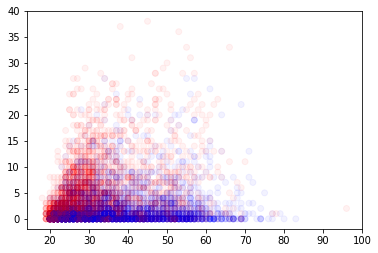

In [35]:
# Scatterpolot of age vs. priors, colored by two_year_recid
colors = cv.two_year_recid.apply(lambda x: 'red' if x else 'blue')
plt.scatter(cv.age, cv.priors_count, c=colors, alpha=0.05)

In [36]:
# add a  noise to the values in the array
def jitter(arr):
    # pick a standard deviation for the jitter of 3% of the data range
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

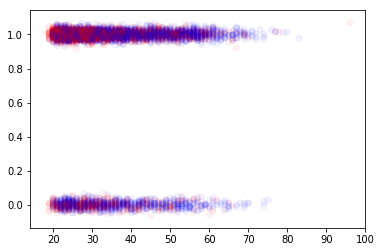

In [37]:
# Scatterpolot of age vs. sex, colored by two_year_recid
plt.scatter(cv.age, jitter(features.sex_Male), c=colors, alpha=0.05)

There is no way to draw a line (even a curved line) that cleanly separates the red (recidivated) and blue (did not recidivate) dots. We can do a little better by looking at more than two axes at a time, and might be able to imagine fitting a curved plane, but it's still not possible to separate red and blue enough to give us a very accurate classifier.